# Housekeeping

In [78]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data Gathering and Plotting

In [79]:
timespan = 365

def get_data():
    BRENT = yf.download("BZ=F", auto_adjust=True, period = 'max')["Close"]
    WTI = yf.download("CL=F", auto_adjust=True, period = 'max')["Close"]

    df = pd.concat([BRENT, WTI], axis=1)
    df.columns = ['BRENT', 'WTI']

    df = df = df.iloc[-timespan:]
    print(df.head())
    return df.dropna()

def plot_price_data(df):
    plt.figure(figsize=(8,5))
    plt.plot(df['BRENT'], label = 'BRENT Close')
    plt.plot(df['WTI'], label = 'WTI Close')
    plt.title('BRENT vs WTI Close prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

df = get_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                BRENT        WTI
Date                            
2024-01-23  79.550003  74.370003
2024-01-24  80.040001  75.089996
2024-01-25  82.430000  77.360001
2024-01-26  83.550003  78.010002
2024-01-29  82.400002  76.779999


# Fixing Autocorrelation

In [94]:
from statsmodels.tsa.ar_model import AutoReg

def filter_residuals_ar1(df):
    print("\nFitting AR(1) model on residuals to filter autocorrelation...")
    model_ar = AutoReg(df["residuals"], lags=1).fit()
    df["residuals_adj"] = df["residuals"] - model_ar.predict(start=1, end=len(df)-1)
    df["residuals_adj"].iloc[0] = df["residuals"].iloc[0]  # fill first value as is
    print(model_ar.summary())
    return df

# Calculating Spread and Z-Score

In [95]:
def calculate_spread_zscore(df):

    df['spread'] = df['BRENT'] - df['WTI']
    
    df['spread_mean'] = df['spread'].rolling(window=30).mean()
    df['spread_std'] = df['spread'].rolling(window=30).std()
    
    # Z-score calculation
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    # Plotting the spread
    plt.figure(figsize=(8,5))
    plt.plot(df['spread'], label='BRENT-WTI Spread')
    plt.plot(df['spread_mean'], label='20-Day Moving Average')
    plt.title('BRENT-WTI Spread and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the z-score
    plt.figure(figsize=(8,5))
    plt.plot(df['zscore'], label='Z Score', color='green')
    plt.axhline(-1, color='red', linestyle='--', label='-1 Threshold')
    plt.axhline(1, color='red', linestyle='--', label='1 Threshold')
    plt.title('BRENT-WTI Z-Score')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df


# Prove that Spread is Suitable for Arbitrage

In [108]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series)
    if result[1] < 0.05:  # p-value less than 0.05 means reject H0
        print("Stationary (reject H₀) - spread mean and variance are constant, suitable for prediction and modeling \n")
    else:
        print("Non-stationary (cannot reject H₀) - spread mean and variance change over time, not suitable for direct prediction \n")

# Strategy and Returns Calculation

In [109]:
#Buy and Sell Signals

def define_signals(df):
    df['position'] = 0
    df.loc[df['zscore'] > 1, 'position'] = -1
    df.loc[df['zscore'] < -1, 'position'] = 1
    df.loc[(df['zscore'] > -0.5) & (df['zscore'] < 0.5), 'position'] = 0
    return df

def explicit_positions(df):
    df['BRENT_position'] = 0
    df['WTI_position'] = 0
    df.loc[df['position'] == 1, ['BRENT_position', 'WTI_position']] = [1, -1]
    df.loc[df['position'] == -1, ['BRENT_position', 'WTI_position']] = [-1, 1]
    return df

def calculate_returns(df):
    df['BRENT_returns'] = df['BRENT'].pct_change()
    df['WTI_returns'] = df['WTI'].pct_change()

    df['strategy_returns_explicit'] = (
        df['BRENT_position'].shift(1) * df['BRENT_returns'] +
        df['WTI_position'].shift(1) * df['WTI_returns']
    )

    df['strategy_cumulative_explicit'] = (1 + df['strategy_returns_explicit'].fillna(0)).cumprod()
    return df

    

# Performance Summary and Running Code

In [110]:
def performance_summary(df, risk_free_rate=0):
    
    BRENT_Return = (df['BRENT_returns'].dropna() + 1).prod() - 1
    WTI_Return = (df['WTI_returns'].dropna() + 1).prod() - 1

    pnl_pct = (df['strategy_cumulative_explicit'].iloc[-1] - 1) * 100
    mean_ret = df['strategy_returns_explicit'].mean()
    std_ret = df['strategy_returns_explicit'].std()

    sharpe = (mean_ret - risk_free_rate / 252) / std_ret * np.sqrt(252)

    print(f"BRENT WTI Arbitrage Strategy P&L: {pnl_pct:.2f}%")
    print(f"BRENT WTI Arbitrage Strategy Sharpe Ratio: {sharpe:.2f}")
    print(f"BRENT Price Change: {BRENT_Return * 100:.2f}%")
    print(f"WTI Price Change: {WTI_Return * 100:.2f}%")


def main():
    df = get_data()
    plot_price_data(df)
    df = calculate_spread_zscore(df)
    adf_test(df['spread'], 'spread')


    df = define_signals(df)
    df = explicit_positions(df)
    df = calculate_returns(df)
    
    performance_summary(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                BRENT        WTI
Date                            
2024-01-23  79.550003  74.370003
2024-01-24  80.040001  75.089996
2024-01-25  82.430000  77.360001
2024-01-26  83.550003  78.010002
2024-01-29  82.400002  76.779999


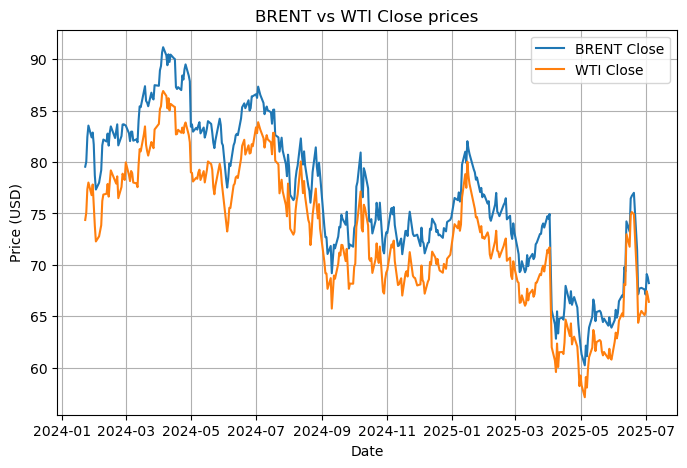

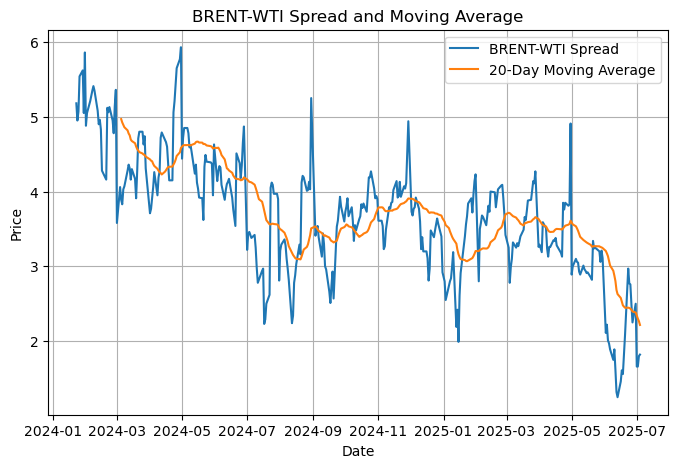

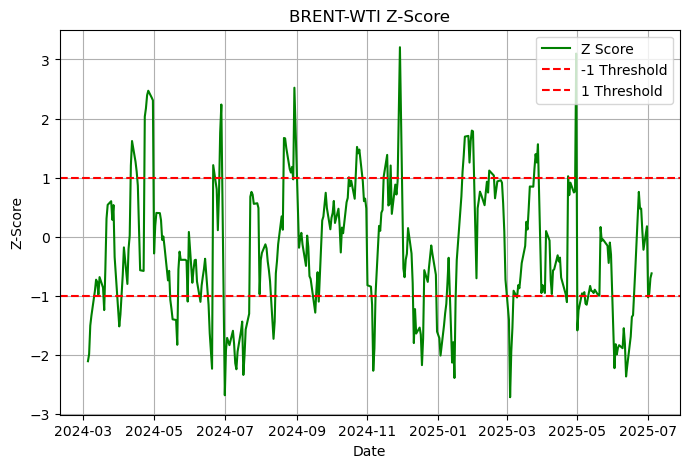

Stationary (reject H₀) - spread mean and variance are constant, suitable for prediction and modeling 

BRENT WTI Arbitrage Strategy P&L: 24.21%
BRENT WTI Arbitrage Strategy Sharpe Ratio: 2.61
BRENT Price Change: -14.23%
WTI Price Change: -10.70%


In [111]:
main()